# Import infection rate from .csv file, plot and fit

## Data source (Public Health England):


## https://www.arcgis.com/sharing/rest/content/items/e5fd11150d274bebaaf8fe2a7a2bda11/data

In [41]:
# Libraries
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date

In [7]:
# load csv file and save number of infections
Infections = []
with open('DailyConfirmedCases.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # skip first row with column headings
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            Infections.append(row[2])
            line_count += 1
    print(f'Processed {line_count} lines.')

Infections = np.asarray(Infections,dtype = 'float')

print('Total infections so far: ' + str(Infections[-1]) )

Processed 51 lines.
Total infections so far: 3983.0


In [3]:
# Models (fit functions)

# exponential growth from an initial population size
def simple_expo(x,a,b,c):
    return a * np.exp(-b * x) + c

# linear and exponential growth (supposed to model imported cases + normal spreading)
def linear_expo(x,m,a,b,c):
    return (m*x + a*np.exp(-b*x) + c)

# simple epidemiological model assuming a maximum "carrying capacity" (max. # cases)
def logistic(x,K,P0,r):
    return K/(1+((K-P0)/P0)*np.exp(-r*x))

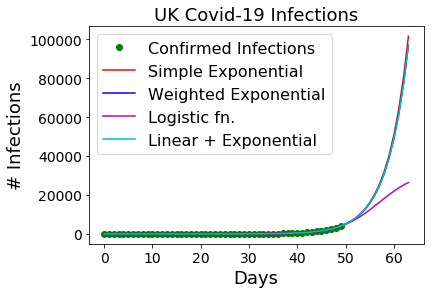

In [11]:
# plot infection data, fit functions
Days = np.arange(0,len(Infections),1)
Days_long = np.arange(0,len(Infections)+14)
FS = 18
plt.plot(Days,Infections,'o',color = 'green', markersize = 6,label = 'Confirmed Infections')
plt.ylabel('# Infections',fontsize = FS)
plt.xlabel('Days',fontsize = FS)
plt.title('UK Covid-19 Infections', fontsize = FS)

# fit functions
p_lin, pc_lin = curve_fit(simple_expo, Days, Infections,p0 = (0.3,-0.5,5))


weight_fac = 10
weight_fn = np.arange(weight_fac, 1, -(weight_fac-1) /len(Infections))

p_lin_w, pc_lin_w = curve_fit(simple_expo, Days, Infections,p0 = (0,-0.5,5),\
                          sigma = weight_fn, bounds = ([-10,-10.,0],[10.,10.,6]))

p_linexp, pc_linexp = curve_fit(linear_expo, Days, Infections,p0 = (1,0,-0.5,5))


p_log, pc_log = curve_fit(logistic, Days, Infections,p0 = (9999,1,0.23),maxfev=5000\
                         ,bounds = ([1500,0,0],[np.inf,30,np.inf]))

#plt.plot(Days,simple)
plt.plot(Days_long, simple_expo(Days_long, *p_lin), 'r-',label = 'Simple Exponential')
plt.plot(Days_long, simple_expo(Days_long, *p_lin_w), 'b-',label = 'Weighted Exponential')
plt.plot(Days_long, logistic(Days_long, *p_log), 'm-',label = 'Logistic fn.')
plt.plot(Days_long, linear_expo(Days_long, *p_linexp), 'c-',label = 'Linear + Exponential')


plt.legend(fontsize = FS-2)
plt.xticks(fontsize = FS-4)
plt.yticks(fontsize = FS-4);


In [9]:
# predict next day infection rate from fit extrapolation
# doubling rate and max # infections (logistic fit only)
def next_day_predict(fn,params,cov,Day_1):
    pred = np.round(fn(Day_1,*params))
    day_before = np.round(fn(Day_1-1,*params))
    pred_up = np.round(fn(Day_1,*(params-np.sqrt(np.diag(cov)))))
    return str(pred-day_before) + '+/-' + str(np.abs(pred_up-pred))

print('Simple next day new cases: ' + \
      next_day_predict(simple_expo,p_lin,pc_lin,Days[-1]+1))

print('Recent-weighted next day new cases: ' + \
      next_day_predict(simple_expo,p_lin_w,pc_lin_w,Days[-1]+1))

print('Linear + Expo. next day new cases: ' + \
      next_day_predict(linear_expo,p_linexp,pc_linexp,Days[-1]+1))

print('Logisitic next day new cases: ' + \
      next_day_predict(logistic,p_log,pc_log,Days[-1]+1))

print('')

print('Simple doubling time (days): ' + str(np.round(-np.log(2)/p_lin[1],2)))
print('Weighted doubling time (days): ' + str(np.round(-np.log(2)/p_lin_w[1],2)))
print('Logisitic doubling time (days): ' + str(np.round(np.log(2)/p_log[2],2)))

print('')

# peak infections uncertainty is very high...
print('Peak infections: ' + str(np.round(p_log[0])) + '+/-' \
      + str(np.round(-p_log[0]+np.sqrt(pc_log[0,0]))))

Simple next day new cases: 1048.0+/-17.0
Recent-weighted next day new cases: 1027.0+/-80.0
Linear + Expo. next day new cases: 1033.0+/-104.0
Logisitic next day new cases: 946.0+/-2333.0

Simple doubling time (days): 3.01
Weighted doubling time (days): 3.05
Logisitic doubling time (days): 2.82

Peak infections: 32421.0+/--19851.0


In [10]:
# residuals (which model best matches data)

def sum_residuals (Data,model):
    return (np.sum((Data-model)**2))

print(sum_residuals(Infections,simple_expo(Days, *p_lin)))
print(sum_residuals(Infections,simple_expo(Days, *p_lin_w)))
print(sum_residuals(Infections,linear_expo(Days, *p_linexp)))
print(sum_residuals(Infections,logistic(Days, *p_log)))



47498.016618069276
50038.307083618834
45068.81206304674
42146.55836169786


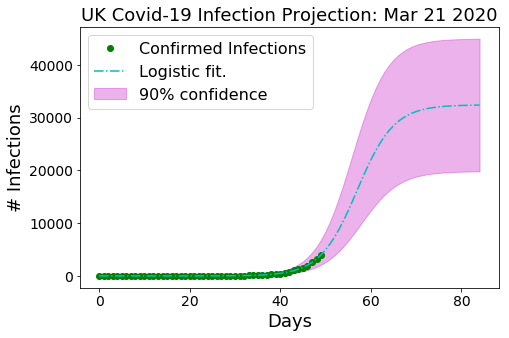

In [52]:
#logistic fit range of outcomes
Days_longer = np.arange(0,85)
y0 = logistic(Days_longer, *p_log)
y_up = logistic(Days_longer, *(p_log-np.sqrt(np.diag(pc_log))))
y_do = logistic(Days_longer, *(p_log+np.sqrt(np.diag(pc_log))))

plt.rcParams["figure.figsize"] = [7.5, 4.8]
fig, ax1 = plt.subplots()
ax1.fill_between(Days_longer, y_do, y_up,color = 'm', alpha = 0.3, label = '90% confidence')

plt.plot(Days,Infections,'o',color = 'green', markersize = 6,label = 'Confirmed Infections')
plt.plot(Days_longer, logistic(Days_longer, *p_log), 'c-.',label = 'Logistic fit.')

plt.xticks(fontsize = FS-4)
plt.yticks(fontsize = FS-4)
plt.legend(fontsize = FS-2, loc = 'upper left')
plt.ylabel('# Infections',fontsize = FS)
plt.xlabel('Days',fontsize = FS)
plt.title('UK Covid-19 Infection Projection: ' \
          + (date.today()).strftime("%b %d %Y"), fontsize = FS)
plt.savefig('Logistic_projection.png',bbox_inches='tight')